In [2]:
import torch
import matplotlib.pyplot as plt
import ternary
import numpy as np
from scipy.stats import entropy

from torch.utils.data import DataLoader
from IPython.display import clear_output
from torchsummary import summary

from ensemblecalibration.nn_training.train import train_mlp
from ensemblecalibration.nn_training.model import MLPCalW
from ensemblecalibration.nn_training.dataset import MLPDataset
from ensemblecalibration.nn_training.losses import SKCELoss
from ensemblecalibration.nn_training.experiments import experiment_h0_nn, binary_experiment_nn
from ensemblecalibration.calibration.experiments import experiment_h0_feature_dependency, new_experiment_h0
from ensemblecalibration.calibration.calibration_estimates.helpers import calculate_pbar
from ensemblecalibration.calibration.config import config_p_value_analysis
from ensemblecalibration.calibration.plot_functions import plot_scatterplot_ternary
from ensemblecalibration.calibration.p_value_analysis import npbe_test_vaicenavicius
from ensemblecalibration.sampling import multinomial_label_sampling


#### Binary setting:

In [3]:
N_INST_TRAIN = 5000
N_INST_TEST = 1000
N_CLASSES = 2
N_ENS = 3
N_EPOCHS = 1000
LR = 0.0001
BATCH_SIZE = 128
HIDDEN_DIM = 256
BW = 0.5
loss = SKCELoss(bw = BW)

new experiment: use entropy as function for weights

In [4]:
p_probs, y_labels, weights = experiment_h0_nn(N_INST_TRAIN, N_CLASSES, N_ENS)

In [13]:
dataset_train = MLPDataset(P=p_probs, y=y_labels)

loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=False)

real_loss = loss(torch.from_numpy(p_probs).float(), torch.from_numpy(weights).float(), torch.from_numpy(y_labels))
print(f"Real value of miscalibration loss: {real_loss}")

model, loss_train = train_mlp(dataset_train=dataset_train, loss=loss, n_epochs=N_EPOCHS, print_losses=True,
                              every_n_epoch=10, optim=torch.optim.Adam)

Real value of miscalibration loss: 1.371343631099281e-13
Epoch: 9 train loss: 1.6006644828655867e-08
Epoch: 19 train loss: 1.6012970518143533e-08
Epoch: 29 train loss: 1.6014133737799763e-08


KeyboardInterrupt: 

summary of model:

In [6]:
summary(model, input_size=(N_ENS, N_CLASSES))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 3, 32]              96
            Linear-2                [-1, 3, 32]           1,056
            Linear-3                 [-1, 3, 1]              33
              ReLU-4                 [-1, 3, 1]               0
           Softmax-5                    [-1, 3]               0
Total params: 1,185
Trainable params: 1,185
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


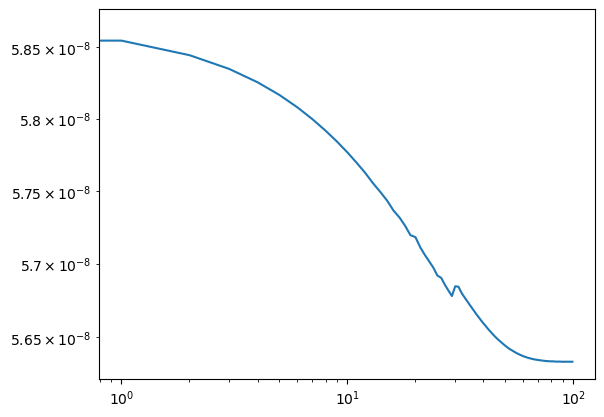

In [41]:
plt.loglog(loss_train)


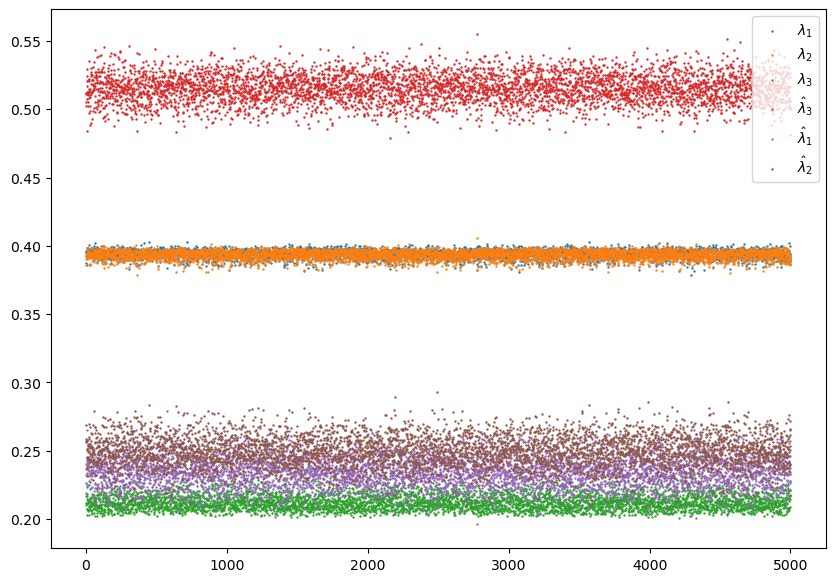

In [42]:
weights_pred = model(torch.from_numpy(p_probs).float()).detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
x = np.linspace(0, N_INST_TRAIN, N_INST_TRAIN)
ax.scatter(x, weights[:, 0], s=0.5, label = "$\lambda_1$")
ax.scatter(x, weights[:, 1],s=0.5, label = "$\lambda_2$")
ax.scatter(x, weights[:, 2], s=0.5, label = "$\lambda_3$")

ax.scatter(x, weights_pred[:, 2], s=0.5, label = "$\hat{\lambda}_3$")
ax.scatter(x, weights_pred[:, 0], s=0.5, label = "$\hat{\lambda}_1$")
ax.scatter(x, weights_pred[:, 1], s=0.5, label = "$\hat{\lambda}_2$")

plt.legend()

In [54]:
summary(model, input_size=p_probs.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 2, 32]              96
            Linear-2                [-1, 2, 32]           1,056
            Linear-3                 [-1, 2, 1]              33
              ReLU-4                 [-1, 2, 1]               0
           Softmax-5                    [-1, 2]               0
Total params: 1,185
Trainable params: 1,185
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


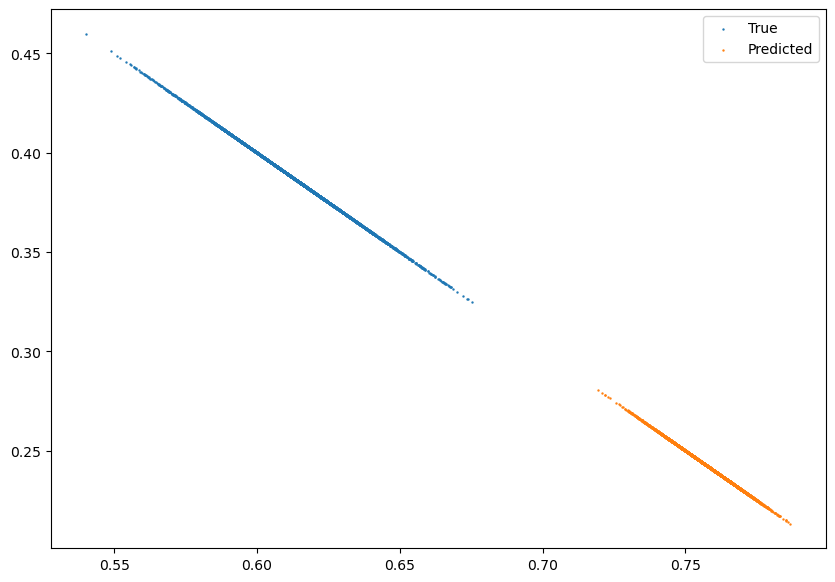

In [43]:
p_bar_pred = calculate_pbar(weights_pred, p_probs, reshape=True, n_dims=2)
p_bar = calculate_pbar(weights, p_probs, reshape=True, n_dims=2)


fig, ax = plt.subplots(1,1 , figsize=(10, 7))
ax.scatter(p_bar[:, 0], p_bar[:, 1], s=0.5, label = "True")
ax.scatter(p_bar_pred[:, 0], p_bar_pred[:, 1], s=0.5, label = "Predicted")
plt.legend()

In [52]:
weights.shape

(5000, 2)

In [14]:
p_probs, y_labels, weights = binary_experiment_nn(n_instances=N_INST_TRAIN, n_classes=N_CLASSES, fct="sin", period_cycle=100, uct=0.1)

In [16]:
dataset_train = MLPDataset(P=p_probs, y=y_labels)

loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=False)

loss_real = loss(torch.from_numpy(p_probs).float(), torch.from_numpy(weights).float(), torch.from_numpy(y_labels))
print(f"Real value of miscalibration loss: {loss_real}")

model, loss_train = train_mlp(dataset_train=dataset_train, loss=loss, n_epochs=N_EPOCHS, print_losses=True,
                              every_n_epoch=10)

Real value of miscalibration loss: 3.761476108365969e-08
Epoch: 9 train loss: 8.998670210758064e-07
Epoch: 19 train loss: 8.990767583816339e-07
Epoch: 29 train loss: 8.98993912795687e-07
Epoch: 39 train loss: 8.989262439806911e-07
Epoch: 49 train loss: 8.988711536095372e-07
Epoch: 59 train loss: 8.988237723328574e-07
Epoch: 69 train loss: 8.987814885563771e-07
Epoch: 79 train loss: 8.987433155527303e-07
Epoch: 89 train loss: 8.987077055377935e-07
Epoch: 99 train loss: 8.986751817263717e-07
Epoch: 109 train loss: 8.98643953617384e-07
Epoch: 119 train loss: 8.986136848854187e-07
Epoch: 129 train loss: 8.985857300303213e-07
Epoch: 139 train loss: 8.985579164733082e-07
Epoch: 149 train loss: 8.985316221732376e-07
Epoch: 159 train loss: 8.98505830027041e-07
Epoch: 169 train loss: 8.984808465561933e-07
Epoch: 179 train loss: 8.984563993175155e-07
Epoch: 189 train loss: 8.984319030735932e-07
Epoch: 199 train loss: 8.984086740826402e-07
Epoch: 209 train loss: 8.983856279287661e-07
Epoch: 219 t

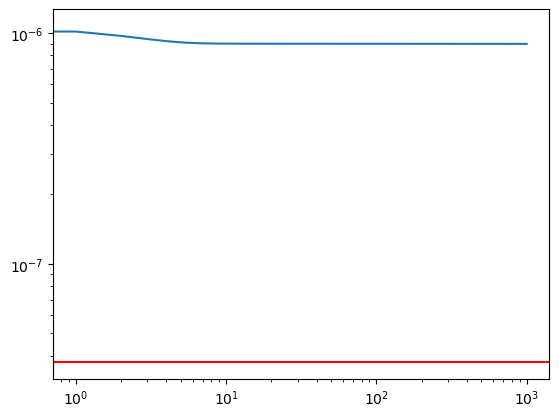

In [19]:
plt.loglog(loss_train)
loss_real = loss(torch.from_numpy(p_probs).float(), torch.from_numpy(weights).float(), torch.from_numpy(y_labels))
plt.axhline(loss_real, color="red")

calculate predicted cc:

In [17]:
weights_pred = model(torch.from_numpy(p_probs).float()).detach().numpy()
weights_pred - weights

array([[-0.01198149,  0.01198143],
       [-0.0776473 ,  0.07764733],
       [-0.12874308,  0.12874311],
       ...,
       [-0.05676287,  0.05676293],
       [-0.18636867,  0.18636864],
       [-0.21278745,  0.21278748]], dtype=float32)

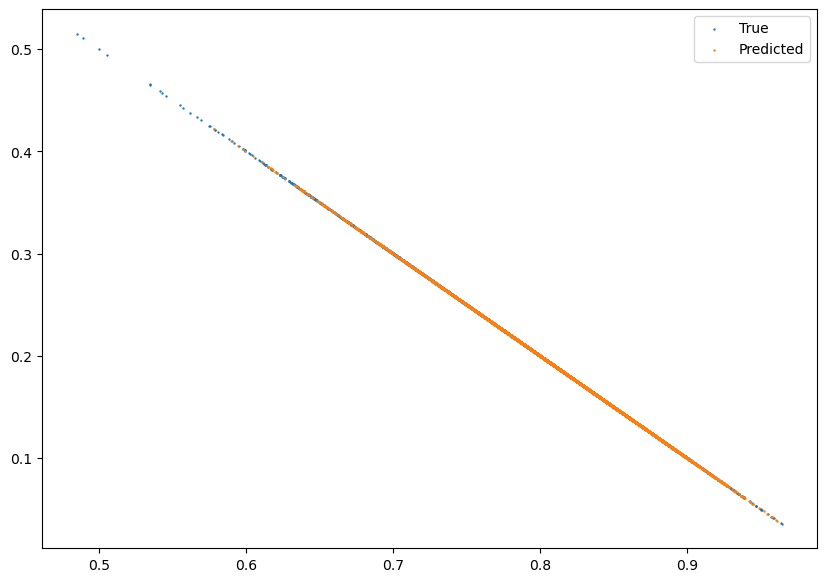

In [18]:
p_bar_pred = calculate_pbar(weights_pred, p_probs, reshape=True, n_dims=2)
p_bar = calculate_pbar(weights, p_probs, reshape=True, n_dims=2)


fig, ax = plt.subplots(1,1 , figsize=(10, 7))
ax.scatter(p_bar[:, 0], p_bar[:, 1], s=0.5, label = "True")
ax.scatter(p_bar_pred[:, 0], p_bar_pred[:, 1], s=0.5, label = "Predicted")
plt.legend()



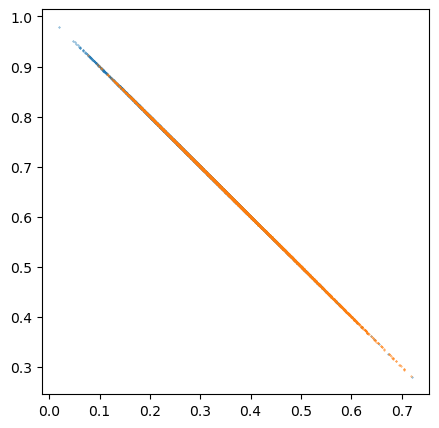

In [36]:
fig, ax = plt.subplots(1,1,
                        figsize=(5,5))

ax.scatter(p_probs[:, 0, 0], p_probs[:, 0, 1], s=0.1)
ax.scatter(p_probs[:, 1, 0], p_probs[:, 1, 1], s=0.1)

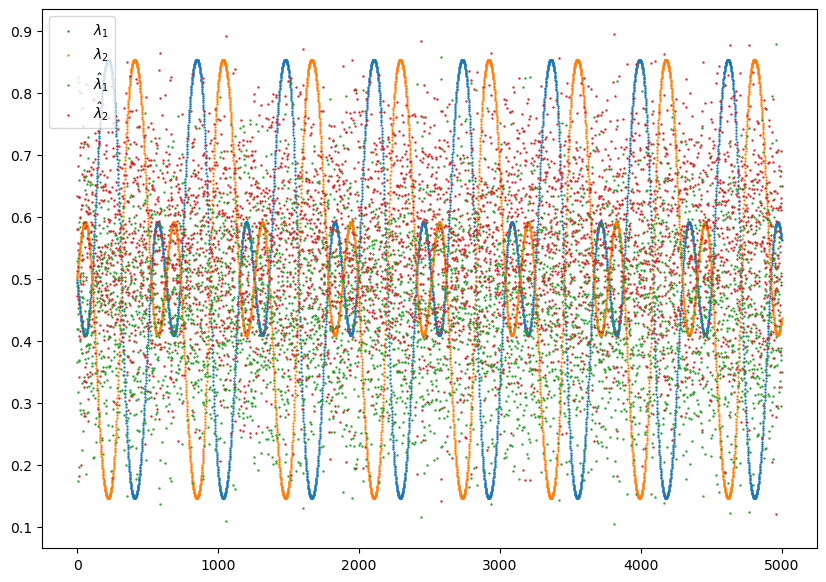

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
x = np.linspace(0, N_INST_TRAIN, N_INST_TRAIN)
ax.scatter(x, weights[:, 0], s=0.5, label = "$\lambda_1$")
ax.scatter(x, weights[:, 1],s=0.5, label = "$\lambda_2$")
ax.scatter(x, weights_pred[:, 0], s=0.5, label = "$\hat{\lambda}_1$")
ax.scatter(x, weights_pred[:, 1], s=0.5, label = "$\hat{\lambda}_2$")
plt.legend()

In [52]:
def softmax(x, axis=1):
    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e_x / e_x.sum(axis=axis, keepdims=True)

def weight_function(predictions):
    # Use the softmax function on the sum of the model predictions across classes
    return softmax(np.sum(predictions, axis=2), axis=1)

# Calculate raw weights for each instance
weights = weight_function(predictions)

# Combine the predictions using the weights
combined_predictions = np.sum(weights[:, :, None] * predictions, axis=1)

0.6931471805599453

### Evaluation of training an MLP to predict optimal convex combination of ensemble classifier models:


Define parameters:

generate training and test data, initialise dataset: use setting where a different prior parameter is sampled for each ensemble,
but the same is used for every instance.

In [60]:
p_probs_train, y_labels, l_weights = new_experiment_h0(N_INST_TRAIN, N_ENS, N_CLASSES,uct=1, feature_dependent=True)

p_bar = calculate_pbar(weights_l=l_weights, P=p_probs_train, reshape=True, n_dims=2)
dataset_train = MLPDataset(P=p_probs_train, y=y_labels)

loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)


(5000,)

training loop_ plot real and predicted "optimal" classifier probabilities during training

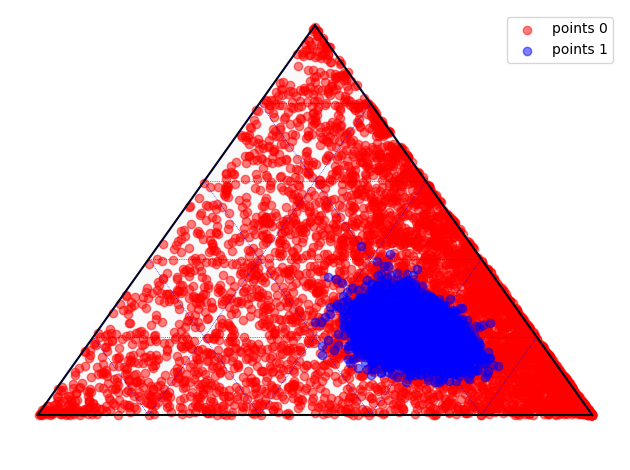

Epoch: 9 train loss: 3.325328696565164e-07


In [55]:
model = MLPCalW(in_channels=N_CLASSES, hidden_dim=HIDDEN_DIM)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_train = np.zeros(N_EPOCHS)
loss = SKCELoss()

for epoch in range(N_EPOCHS):
    loss_epoch = []
    model.train()
    for i, (p_probs, y_labels) in enumerate(loader_train):
        p_probs = p_probs.float()
        weights_l = model(p_probs)
        l = loss(p_probs, weights_l, y_labels)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        loss_epoch.append(l.item())
    loss_n = sum(loss_epoch)/(len(loader_train))
    loss_train[epoch] = loss_n

    clear_output(wait=True)
    # plot precited and real probabiility scores
    l_weights_calc = model(torch.from_numpy(p_probs_train).float())
    p_bar_calc = calculate_pbar(weights_l=l_weights_calc.detach().numpy(), P=p_probs_train, reshape=True, n_dims=2)
    plot_scatterplot_ternary([p_bar, p_bar_calc], ["red", "blue"], scale=1)
    plt.show()
    print(f"Epoch: {epoch} train loss: {loss_n}")

In [10]:
model, loss_train = train_mlp(dataset_train=dataset_train, loss=loss, n_epochs=N_EPOCHS)

Epoch: 0 train loss: 1.1924362678681312e-09
Epoch: 1 train loss: 1.1828205938657304e-09
Epoch: 2 train loss: 1.1734795234277592e-09
Epoch: 3 train loss: 1.164992140872369e-09
Epoch: 4 train loss: 1.1573284028235062e-09
Epoch: 5 train loss: 1.1500501638618191e-09
Epoch: 6 train loss: 1.1430680043663736e-09
Epoch: 7 train loss: 1.1363642544591114e-09
Epoch: 8 train loss: 1.1300779017287153e-09
Epoch: 9 train loss: 1.1241078195424053e-09


calculate predicted probailities with found c.c.

In [11]:
l_weights_calc = model(torch.from_numpy(p_probs_train).float())
p_bar = calculate_pbar(weights_l=l_weights, P=p_probs_train, reshape=True, n_dims=2)
p_bar_calc = calculate_pbar(weights_l=l_weights_calc.detach().numpy(), P=p_probs_train, reshape=True, n_dims=2)

difference in values of statistics:

In [12]:
val_miscal = config_p_value_analysis["SKCEul"]["params"]["obj_lambda"](l_weights, p_probs_train, y_labels, config_p_value_analysis["SKCEul"]["params"], True)

val_miscal_calc = config_p_value_analysis["SKCEul"]["params"]["obj_lambda"](l_weights_calc.detach().numpy(), p_probs_train, y_labels, config_p_value_analysis["SKCEul"]["params"], True)

print(val_miscal)
print(val_miscal_calc)

0.00030101155047485955
8.318690755629944e-07


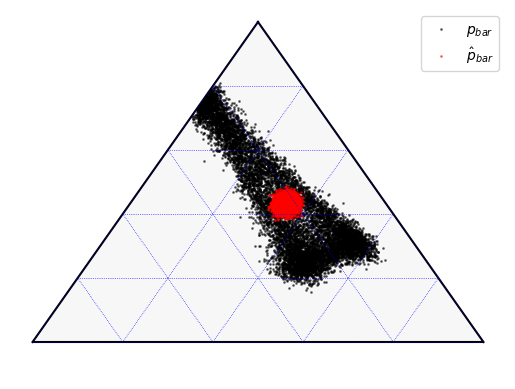

In [13]:
fig, tax = ternary.figure(scale=1)
tax.boundary(linewidth=1.5)

#tax.gridlines(color="black", multiple=.2, linewidth=.5)
tax.gridlines(color="blue", multiple=.2, linewidth=.5)

# Background color
tax.set_background_color(color="whitesmoke", alpha=0.7) # the default, essentially

tax.scatter([tuple(p_bar[i]) for i in range(len(p_bar))], marker='o', color='black', s= 1, alpha=0.5, label='$p_{bar}}$')

tax.scatter([tuple(p_bar_calc[i]) for i in range(len(p_bar_calc))], marker='o', color='red', s= 1, alpha=0.5, label='$\hat{p}_{bar}}$')

tax.legend()

tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

plt.show()

In [90]:
l_weights = np.zeros((N_INST_TRAIN, N_ENS)) + 1/N_ENS

p_probs_train_2 = np.zeros((N_INST_TRAIN, N_ENS, N_CLASSES))
for ens in range(N_ENS):
    for n in range(N_INST_TRAIN):
        # sample prior means
        m = np.random.dirichlet([1/N_CLASSES]*N_CLASSES)

        # sample from  dirichlet distributions 
        p_probs_train_2[n, ens, :] = np.random.dirichlet(m, size=1)

# calculate p_bar, use lambda defined above
p_bar = calculate_pbar(l_weights, p_probs_train_2, reshape=True, n_dims=2)

# sample labels from multinomial distribution
y_labels_2 = np.apply_along_axis(multinomial_label_sampling, 1, p_bar)


In [65]:
p_bar

array([[8.51691371e-01, 7.50847969e-02, 7.32238326e-02],
       [1.84938435e-24, 9.72751198e-01, 2.72488022e-02],
       [2.11840455e-04, 9.99788160e-01, 3.60208575e-96],
       ...,
       [3.55277926e-01, 0.00000000e+00, 6.44722074e-01],
       [1.74860714e-05, 3.36471172e-01, 6.63511342e-01],
       [1.04328047e-03, 9.06188167e-01, 9.27685530e-02]])

In [66]:
p_bar = calculate_pbar(weights_l=l_weights, P=p_probs_train_2, reshape=True, n_dims=2)
dataset_train = MLPDataset(P=p_probs_train_2, y=y_labels_2)
loss = SKCELoss()
loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)

# train MLP
model, loss_train = train_mlp(dataset_train=dataset_train, loss=loss, n_epochs=N_EPOCHS)

Epoch: 0 train loss: 1.1254313721157511e-05
Epoch: 1 train loss: 1.0758374527099906e-05
Epoch: 2 train loss: 1.0707663813597224e-05
Epoch: 3 train loss: 1.0694243466932012e-05
Epoch: 4 train loss: 1.0696823481140191e-05
Epoch: 5 train loss: 1.0701451640117432e-05
Epoch: 6 train loss: 1.0704646297618169e-05
Epoch: 7 train loss: 1.0704431009744413e-05
Epoch: 8 train loss: 1.0703636704713923e-05
Epoch: 9 train loss: 1.0704251958414372e-05
Epoch: 10 train loss: 1.070088472646699e-05
Epoch: 11 train loss: 1.0699412012368618e-05
Epoch: 12 train loss: 1.0699561721272615e-05
Epoch: 13 train loss: 1.0696086593675602e-05
Epoch: 14 train loss: 1.0694489810224306e-05
Epoch: 15 train loss: 1.0692914889250982e-05
Epoch: 16 train loss: 1.0691343793811128e-05
Epoch: 17 train loss: 1.0689778766178986e-05
Epoch: 18 train loss: 1.0688233963828536e-05
Epoch: 19 train loss: 1.068671534462072e-05
Epoch: 20 train loss: 1.0685226741827952e-05
Epoch: 21 train loss: 1.0683770370862462e-05
Epoch: 22 train loss: 

In [91]:
l_weights_calc = model(torch.from_numpy(p_probs_train_2).float())
p_bar_calc = calculate_pbar(weights_l=l_weights_calc.detach().numpy(), P=p_probs_train_2, reshape=True, n_dims=2)

# calculate value of miscalibration estimates for both lambda vectors
val_miscal = config_p_value_analysis["SKCEul"]["params"]["obj_lambda"](l_weights, p_probs_train_2, y_labels_2, config_p_value_analysis["SKCEul"]["params"], True)

val_miscal_calc = config_p_value_analysis["SKCEul"]["params"]["obj_lambda"](l_weights_calc.detach().numpy(), p_probs_train_2, y_labels_2, config_p_value_analysis["SKCEul"]["params"], True)

print(np.round(val_miscal, 5))
print(np.round(val_miscal_calc, 5))

3e-05
-0.0003


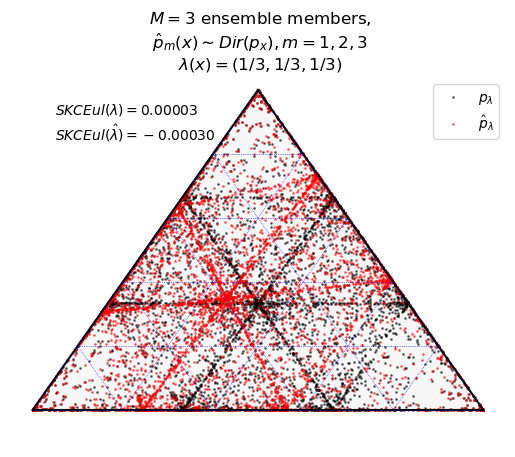

In [93]:
fig, tax = ternary.figure(scale=1)
tax.boundary(linewidth=1.5)

# tax.gridlines(color="black", multiple=.2, linewidth=.5)
tax.gridlines(color="blue", multiple=0.2, linewidth=0.5)

# Background color
tax.set_background_color(color="whitesmoke", alpha=0.7)  # the default, essentially

tax.scatter(
    [tuple(p_bar[i]) for i in range(len(p_bar))],
    marker="o",
    color="black",
    s=1,
    alpha=0.5,
    label="$p_{\lambda}$",
)

tax.scatter(
    [tuple(p_bar_calc[i]) for i in range(len(p_bar_calc))],
    marker="o",
    color="red",
    s=1,
    alpha=0.5,
    label="$\hat{p}_{\lambda}}$",
)

tax.legend()
plt.title(
    " $M=3$ ensemble members,\n $\hat{p}_m(x) \sim Dir(p_x), m=1,2,3$ \n $\lambda(x) = (1/3, 1/3, 1/3) \forall x$"
)
plt.text(0.05, 0.8, f"$SKCEul(\lambda)={val_miscal:.5f}$")
plt.text(0.05, 0.73, f"$SKCEul(\hat{{\lambda}})={val_miscal_calc:.5f}$")
tax.clear_matplotlib_ticks()
tax.get_axes().axis("off")

plt.show()


In [71]:
# calculate value of miscalibration estimates for both lambda vectors
val_miscal = config_p_value_analysis["SKCEul"]["params"]["obj_lambda"](l_weights, p_probs_train_3, y_labels_3, config_p_value_analysis["SKCEul"]["params"], True)

val_miscal_calc = config_p_value_analysis["SKCEul"]["params"]["obj_lambda"](l_weights_calc.detach().numpy(), p_probs_train_3, y_labels_3, config_p_value_analysis["SKCEul"]["params"], True)

print(np.round(val_miscal, 5))
print(np.round(val_miscal_calc, 5))

-7e-05
-4e-05


In [81]:
p_probs_train, y_labels = experiment_h0_feature_dependency(N_INST_TRAIN, N_ENS, N_CLASSES, 0.01)

In [82]:
p_probs_train, y_labels, l_weights = new_experiment_h0(N_INST_TRAIN, N_ENS, N_CLASSES, feature_dependent=True)
dataset_train = MLPDataset(P=p_probs_train, y=y_labels)

loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)

model, loss_train = train_mlp(dataset_train=dataset_train, loss=loss, n_epochs=N_EPOCHS)

Epoch: 0 train loss: 3.682558010466474e-10
Epoch: 1 train loss: 3.666158785470505e-10
Epoch: 2 train loss: 3.6510590817853586e-10
Epoch: 3 train loss: 3.6356480266595024e-10
Epoch: 4 train loss: 3.62087349207031e-10
Epoch: 5 train loss: 3.6060746629905447e-10
Epoch: 6 train loss: 3.5915076030231453e-10
Epoch: 7 train loss: 3.577121762122733e-10
Epoch: 8 train loss: 3.5628623982236655e-10
Epoch: 9 train loss: 3.5488495616579213e-10
Epoch: 10 train loss: 3.5348162724991075e-10
Epoch: 11 train loss: 3.520562924366944e-10
Epoch: 12 train loss: 3.5066324253464566e-10
Epoch: 13 train loss: 3.492914205535479e-10
Epoch: 14 train loss: 3.4794074919740947e-10
Epoch: 15 train loss: 3.465963849131403e-10
Epoch: 16 train loss: 3.452281687609551e-10
Epoch: 17 train loss: 3.4389365502597485e-10
Epoch: 18 train loss: 3.426186950708622e-10
Epoch: 19 train loss: 3.413673895906176e-10
Epoch: 20 train loss: 3.401346965150371e-10
Epoch: 21 train loss: 3.3890259518366937e-10
Epoch: 22 train loss: 3.37712592

In [86]:
l_weights_calc = model(torch.from_numpy(p_probs_train).float())
p_bar = calculate_pbar(weights_l=l_weights, P=p_probs_train, reshape=True, n_dims=2)
p_bar_calc = calculate_pbar(weights_l=l_weights_calc.detach().numpy(), P=p_probs_train, reshape=True, n_dims=2)

val_miscal = config_p_value_analysis["SKCEul"]["params"]["obj_lambda"](l_weights, p_probs_train, y_labels, config_p_value_analysis["SKCEul"]["params"], True)

val_miscal_calc = config_p_value_analysis["SKCEul"]["params"]["obj_lambda"](l_weights_calc.detach().numpy(), p_probs_train, y_labels, config_p_value_analysis["SKCEul"]["params"], True)

print(np.round(val_miscal, 6))
print(np.round(val_miscal_calc, 6))
# compare p-values of Vaicenavicius test
#dec, p_val_real, stat = npbe_test_vaicenavicius(p_bar, y_labels, params=config_p_value_analysis["SKCEul"]["params"])

-0.000196
-2e-06


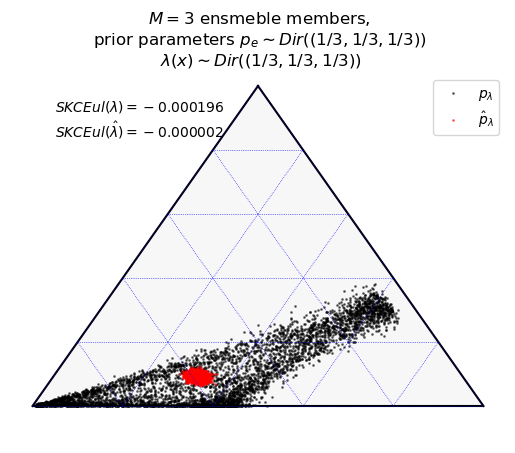

In [88]:
fig, tax = ternary.figure(scale=1)
tax.boundary(linewidth=1.5)

#tax.gridlines(color="black", multiple=.2, linewidth=.5)
tax.gridlines(color="blue", multiple=.2, linewidth=.5)

# Background color
tax.set_background_color(color="whitesmoke", alpha=0.7) # the default, essentially

tax.scatter([tuple(p_bar[i]) for i in range(len(p_bar))], marker='o', color='black', s= 1, alpha=0.5, label='$p_{\lambda}$')

tax.scatter([tuple(p_bar_calc[i]) for i in range(len(p_bar_calc))], marker='o', color='red', s= 1, alpha=0.5, label='$\hat{p}_{\lambda}}$')

tax.legend()
plt.title(" $M=3$ ensmeble members, \n prior parameters $p_e \sim Dir((1/3, 1/3, 1/3))$ \n $\lambda(x) \sim Dir((1/3, 1/3,1/3)) \forall x$")
plt.text(0.05, 0.8, f'$SKCEul(\lambda)={val_miscal:.6f}$')
plt.text(0.05, 0.73, f'$SKCEul(\hat{{\lambda}})={val_miscal_calc:.6f}$')
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

plt.show()

In [ ]:
_, p_val_calc, stat_calc = npbe_test_vaicenavicius(p_bar_calc, y_labels, params=config_p_value_analysis["SKCEul"]["params"])

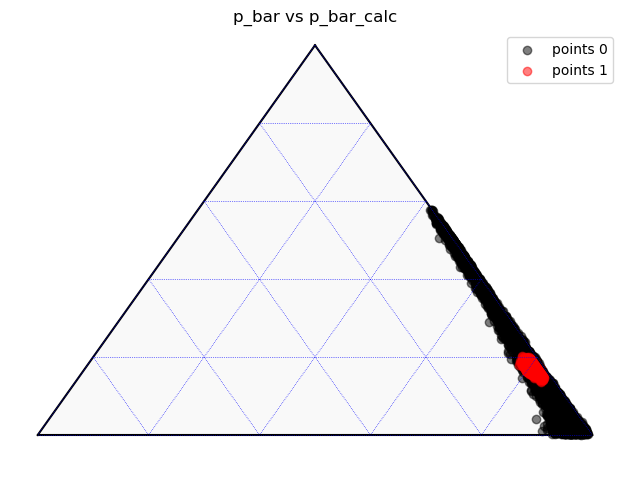

In [63]:
list_points = [p_bar, p_bar_calc]
list_cols = ['black', 'red']
fig = plot_scatterplot_ternary(list_points, list_cols=list_cols, title='p_bar vs p_bar_calc')

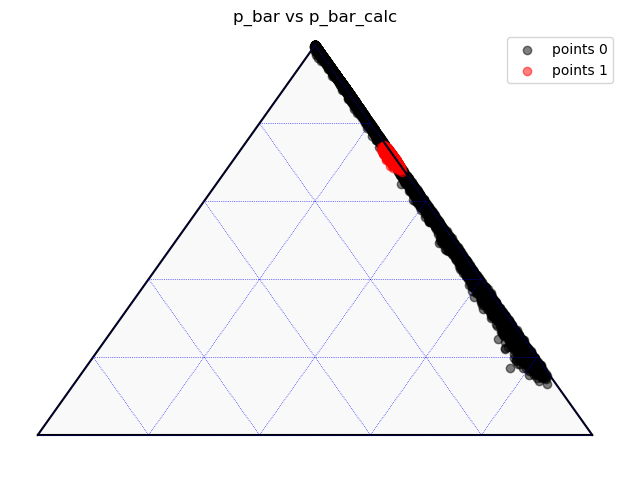

In [17]:
list_points = [p_bar, p_bar_calc]
list_cols = ['black', 'red']
fig = plot_scatterplot_ternary(list_points, list_cols=list_cols, title='p_bar vs p_bar_calc')

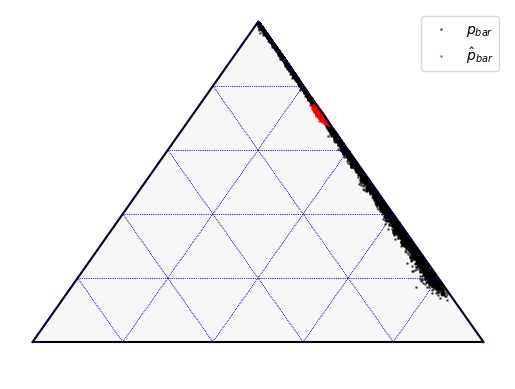

In [18]:
fig, tax = ternary.figure(scale=1)
tax.boundary(linewidth=1.5)

tax.gridlines(color="black", multiple=.2, linewidth=.5)
tax.gridlines(color="blue", multiple=.2, linewidth=.5)

# Background color
tax.set_background_color(color="whitesmoke", alpha=0.7) # the default, essentially

tax.scatter([tuple(p_bar[i]) for i in range(len(p_bar))], marker='o', color='black', s= 1, alpha=0.5, label='$p_{bar}}$')

tax.scatter([tuple(p_bar_calc[i]) for i in range(len(p_bar_calc))], marker='o', color='red', s= 1, alpha=0.5, label='$\hat{p}_{bar}}$')

tax.legend()

tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

plt.show()

In [95]:
import numpy as np
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from ensemblecalibration.nn_training.sampling import sample_binary_predictions

# define parameters
N_SAMPLES = 500
N_FEATURES = 20
N_ENS = 3
N_CLASSES = 2

# create a synthetic dataset
x_samples, p_probs = sample_binary_predictions(N_SAMPLES, N_ENS, lower=0, upper=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [96]:
# sample weights: 
weights = np.zeros((N_SAMPLES, N_ENS))

# let weights increase linearly with value of instance for even indices, decrease linearly for odd 
# indices
for i in range(N_SAMPLES):
    x_norm = x_samples[i]/100
    for j in range(N_ENS):
        if j % 2 == 0:
            weights[i, j] = x_norm
        else:
            weights[i, j] = 1 - x_norm

# Normalize the weights to sum to 1
weights /= np.sum(weights, axis=1, keepdims=True)

In [97]:
weights

array([[0.20598367, 0.58803267, 0.20598367],
       [0.12489671, 0.75020658, 0.12489671],
       [0.28302601, 0.43394798, 0.28302601],
       ...,
       [0.49197483, 0.01605034, 0.49197483],
       [0.49267852, 0.01464296, 0.49267852],
       [0.48054562, 0.03890877, 0.48054562]])

In [66]:
# create an ensemble of classifiers (random forest)
ensemble_size = N_ENS
classifiers = [RandomForestClassifier(max_depth=2, random_state=i) for i in range(ensemble_size)]
for clf in classifiers:
    clf.fit(X_train, y_train)

# generate probabilistic predictions on the test set
predictions = [clf.predict_proba(X_test) for clf in classifiers]  # list of arrays
predictions = np.stack(predictions, axis=0) 
predictions = np.swapaxes(predictions, 0, 1) # shape (n_classifiers, n_samples, n_classes)

In [86]:
def generate_weights(p_probs: np.ndarray):
    # calculate mean of predictions of ensemble for class 1
    mean_predictions = np.mean(p_probs[:, :, 0], axis=1)
    # generate weights based on the difference between the mean and the individual predictions
    weights = np.zeros_like(p_probs[:, :, 0])
    for i in range(len(p_probs)):
        for j in range(len(p_probs[i])):
            weights[i, j] = np.exp(-(p_probs[i, j, 0] - mean_predictions[i])**2)
    # normalize the weights to sum to 1
    weights /= np.sum(weights, axis=1, keepdims=True)
    return weights

In [89]:
weights = generate_weights(p_probs)

In [98]:

combined_predictions = calculate_pbar(weights, p_probs, reshape=True, n_dims=2)
combined_predictions.shape

(500, 2)

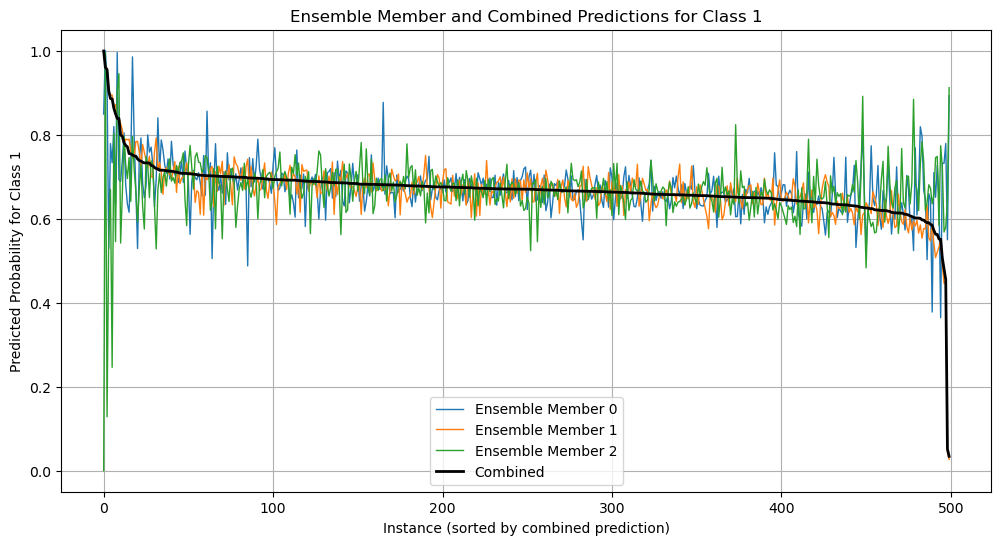

In [100]:
import matplotlib.pyplot as plt

# sort instances by the combined predictions
#sorted_indices = np.argsort(combined_predictions)

plt.figure(figsize=(12, 6))
# sort instances by the combined predictions
sorted_indices = np.argsort(combined_predictions[:, 0])
# plot individual ensemble member predictions
for ens in range(p_probs.shape[1]):
    plt.plot(p_probs[sorted_indices, ens, 1], label=f'Ensemble Member {ens}', linewidth=1)

# plot combined predictions
plt.plot(combined_predictions[sorted_indices, 1], label='Combined', linewidth=2, color='black')

plt.legend()
plt.xlabel('Instance (sorted by combined prediction)')
plt.ylabel('Predicted Probability for Class 1')
plt.title('Ensemble Member and Combined Predictions for Class 1')
plt.grid(True)
plt.show()


### train Perceptron

In [30]:
dataset_train = MLPDataset(p_probs, y_labels)

array([-1.26849258, -1.26278502, -0.66960507, -0.44884558, -0.2393859 ,
       -0.1879443 , -0.18590952, -0.1597347 , -0.08661822,  0.14367765,
        0.21623519,  0.21947091,  0.22017941,  0.22264716,  0.22745233,
        0.22859798,  0.23275247,  0.23947371,  0.24043718,  0.24107801,
        0.24465313,  0.24467326,  0.24816013,  0.25373252,  0.25428327,
        0.25721846,  0.25994473,  0.26123579,  0.26170318,  0.26258761,
        0.26283659,  0.26441098,  0.26730776,  0.26778289,  0.27250634,
        0.27280285,  0.27349121,  0.27376678,  0.2750999 ,  0.27515484,
        0.27763326,  0.27933379,  0.28036497,  0.28131229,  0.28301953,
        0.28454707,  0.28802202,  0.28859066,  0.28900766,  0.28922892,
        0.28980731,  0.29336777,  0.29397545,  0.29546466,  0.2971204 ,
        0.2971219 ,  0.29726613,  0.29777571,  0.29782936,  0.29787138,
        0.29940101,  0.30137325,  0.30165667,  0.30239516,  0.30315644,
        0.30423975,  0.30430333,  0.30787709,  0.30824899,  0.30